# **CS 4644/7643: Deep Learning | Spring 2023**
**Georgia Institute of Technology, Atlanta, GA**

Final Project by,

>*Devashish Gupta*: devashish-gupta@gatech.edu \\
*Divyaansh Singh*: dsingh313@gatech.edu \\
*Sanjay Josh*: sjosh3@gatech.edu \\
*Vastav Bharambe*: vbharambe6@gatech.edu





# **Point Cloud Classification**

#### **Introduction**
Point cloud data is an important type of data used in various applications such as autonomous vehicles, robotics, and virtual reality. Point cloud classification refers to the task of assigning a label to a given point cloud based on its features.

#### **Dataset**
In this notebook, we will be using the ModelNet40 dataset for testing our models. ModelNet40 is a widely-used benchmark dataset for evaluating 3D object classification algorithms. It contains 12,311 CAD models from 10 different categories, with each model represented as a point cloud.

#### **Models**
We will be implementing and comparing three different models for point cloud classification: SimpleView, 3DCTN, and a modified custom version of 3DCTN. SimpleView is a simple yet effective model that uses a fully connected network to classify point clouds. 3DCTN, on the other hand, is a more complex model that uses a 3D convolutional neural network (CNN) to classify point clouds. We will also be modifying the 3DCTN model to see if we can improve its performance.

#### **Adversarial attacks and visualization**
Additionally, we will also be testing each model against adversarial attacks, including one-point attacks and imperceptible noise addition attacks, to evaluate their robustness.


# **Required installations**

In [53]:
# Requirement to use ModelNet40 from the website
!pip install torch-geometric 
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Imports**

In [54]:
import os
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from time import time
import torch.optim as optim
from torch import nn, einsum
import torch.nn.functional as F
# from einops import rearrange, repeat

import torch_geometric.transforms as T
from torch.utils.data import DataLoader
from torch_geometric.datasets import ModelNet
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split

from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from IPython.display import Image

# **Dataset Preparation**

Loading the ModelNet40 dataset and selecting a balanced subset of the dataset for training and testing purposes. We choose a subset of the dataset to reduce computational requirements for effective training.

In [ ]:
# Loading dataset ModelNet40
data_path = './data/ModelNet10'
dataset = ModelNet(root=data_path, name='10', train=True, transform=T.RandomRotate(15, axis=0), pre_transform=T.NormalizeScale())


# Selecting a balanced subset of the dataset
num_classes = 10
num_samples_per_class = 100
balanced_indices = []
labels = [data.y.item() for data in dataset]

for i in range(num_classes):
    class_indices = [idx for idx, label in enumerate(labels) if label == i]
    balanced_indices.extend(class_indices[:min(len(class_indices), num_samples_per_class)])

balanced_subset = torch.utils.data.Subset(dataset, balanced_indices)


# Saving the subset
subset_path = os.path.join(data_path, "balanced_subset.pt")
torch.save(balanced_subset, subset_path)

Extracting data/ModelNet10/ModelNet10.zip
Processing...
Done!


## Test-train split
Splitting the dataset into training and testing sets

In [ ]:
from torch_geometric.data import DataLoader
from torch_geometric.transforms import SamplePoints

# Creating a list of labels for the balanced_subset
balanced_labels = [labels[idx] for idx in balanced_indices]

# Transform models to point clouds by sampling points
num_points = 1024
dataset.transform = T.Compose([T.SamplePoints(num_points), T.RandomRotate(15, axis=0), T.NormalizeScale()])

# Implementing the split between training and testing sets
train_indices, test_indices = train_test_split(list(range(len(balanced_subset))), test_size=0.2, stratify=balanced_labels, random_state=42)

train_subset = torch.utils.data.Subset(balanced_subset, train_indices)
test_subset = torch.utils.data.Subset(balanced_subset, test_indices)

sv_batch_size = 64

# Create DataLoaders for the train and test subsets
train_loader = DataLoader(train_subset, batch_size=sv_batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_subset, batch_size=sv_batch_size, shuffle=False, num_workers=2)


# Saving the splits
train_split_path = os.path.join(data_path, "train_split.pt")
test_split_path = os.path.join(data_path, "test_split.pt")
torch.save(train_subset, train_split_path)
torch.save(test_subset, test_split_path)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Dataset Visualization

Visualizing point clouds for some classes within the dataset.

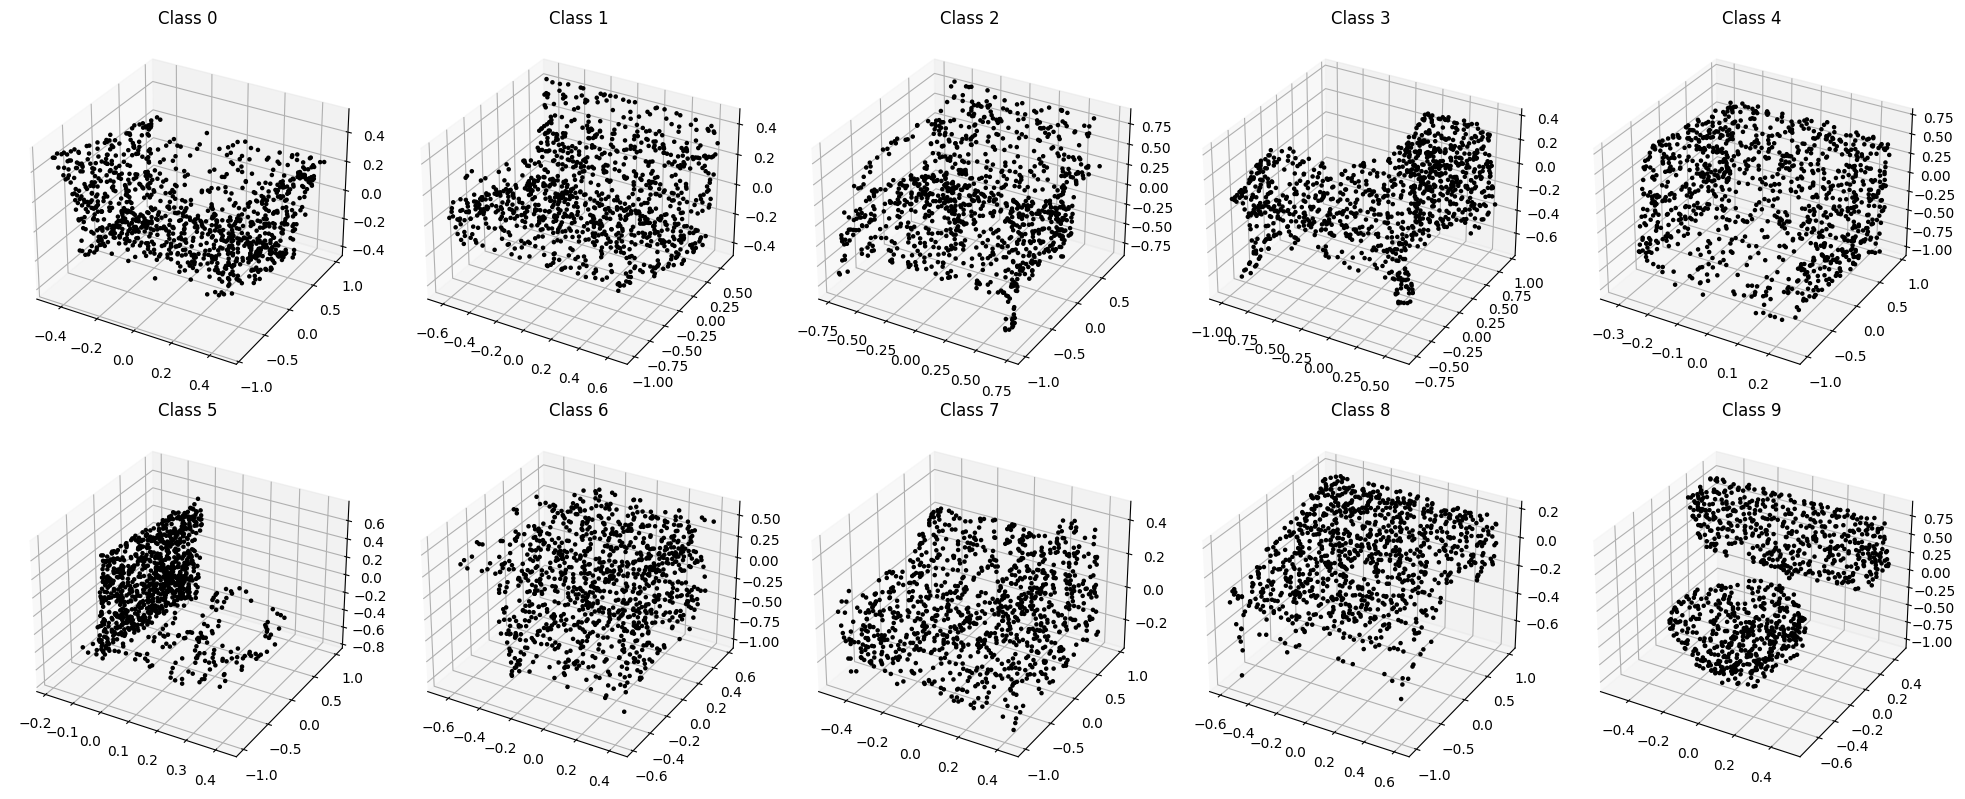

In [64]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Creating a 2x5 grid of visualtizations with 1 model from each class
def visualize_point_cloud(ax, points, title):
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], marker='.', color='black', alpha=1.0)
    ax.set_title(title)

# Visualize one point cloud from each class in a 2x5 grid
fig, axes = plt.subplots(2, 5, figsize=(20, 8), subplot_kw={'projection': '3d'})

for class_idx in range(10):
    class_data = [data for data in dataset if data.y.item() == class_idx]
    row = class_idx // 5
    col = class_idx % 5
    visualize_point_cloud(axes[row, col], class_data[0].pos.numpy(), f"Class {class_idx}")

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.4)

plt.tight_layout()
plt.show()

# Save the grid figure
fig.savefig("visualization_grid_2x5.png")
plt.close(fig)

# **SimpleView Model**

Implementing the SimpleView model as a PyTorch module.

[Paper link]: [Revisiting Point Cloud Shape Classification
with a Simple and Effective Baseline](https://arxiv.org/pdf/2106.05304v1.pdf)

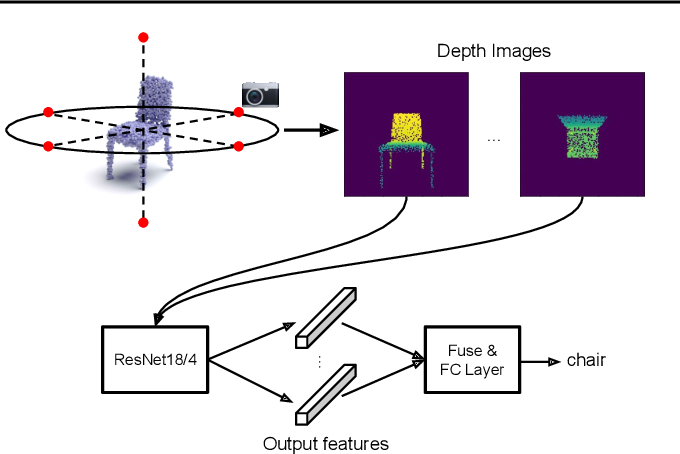

In [60]:
# Figure for the SimpleView model architecture
Image('SimpleView.png', retina=True, width=500)

## Utilities
Defining the utilities such as the project operator, that are an essential part of the SimpleView paradigm.

In [ ]:
# PORT TO MODULE
# Defining utilities for the SimpleView model
import torch.nn as nn
import numpy as np
import torch

RESOLUTION = 128
TRANS = -1.4

def euler2mat(angle):
    if len(angle.size()) == 1:
        x, y, z = angle[0], angle[1], angle[2]
        _dim = 0
        _view = [3, 3]
    elif len(angle.size()) == 2:
        b, _ = angle.size()
        x, y, z = angle[:, 0], angle[:, 1], angle[:, 2]
        _dim = 1
        _view = [b, 3, 3]

    else:
        assert False

    cosz = torch.cos(z)
    sinz = torch.sin(z)

    zero = z.detach()*0
    one = zero.detach()+1
    zmat = torch.stack([cosz, -sinz, zero,
                        sinz, cosz, zero,
                        zero, zero, one], dim=_dim).reshape(_view)

    cosy = torch.cos(y)
    siny = torch.sin(y)

    ymat = torch.stack([cosy, zero, siny,
                        zero, one, zero,
                        -siny, zero, cosy], dim=_dim).reshape(_view)

    cosx = torch.cos(x)
    sinx = torch.sin(x)

    xmat = torch.stack([one, zero, zero,
                        zero, cosx, -sinx,
                        zero, sinx, cosx], dim=_dim).reshape(_view)

    rot_mat = xmat @ ymat @ zmat
    return rot_mat


def distribute(depth, _x, _y, size_x, size_y, image_height, image_width):
    """
    Distributes the depth associated with each point to the discrete coordinates (image_height, image_width) in a region
    of size (size_x, size_y).
    :param depth:
    :param _x:
    :param _y:
    :param size_x:
    :param size_y:
    :param image_height:
    :param image_width:
    :return:
    """

    assert size_x % 2 == 0 or size_x == 1
    assert size_y % 2 == 0 or size_y == 1
    batch, _ = depth.size()
    epsilon = torch.tensor([1e-12], requires_grad=False, device=depth.device)
    _i = torch.linspace(-size_x / 2, (size_x / 2) - 1, size_x, requires_grad=False, device=depth.device)
    _j = torch.linspace(-size_y / 2, (size_y / 2) - 1, size_y, requires_grad=False, device=depth.device)

    extended_x = _x.unsqueeze(2).repeat([1, 1, size_x]) + _i  # [batch, num_points, size_x]
    extended_y = _y.unsqueeze(2).repeat([1, 1, size_y]) + _j  # [batch, num_points, size_y]

    extended_x = extended_x.unsqueeze(3).repeat([1, 1, 1, size_y])  # [batch, num_points, size_x, size_y]
    extended_y = extended_y.unsqueeze(2).repeat([1, 1, size_x, 1])  # [batch, num_points, size_x, size_y]

    extended_x.ceil_()
    extended_y.ceil_()

    value = depth.unsqueeze(2).unsqueeze(3).repeat([1, 1, size_x, size_y])  # [batch, num_points, size_x, size_y]

    # all points that will be finally used
    masked_points = ((extended_x >= 0)
                     * (extended_x <= image_height - 1)
                     * (extended_y >= 0)
                     * (extended_y <= image_width - 1)
                     * (value >= 0))

    true_extended_x = extended_x
    true_extended_y = extended_y

    # to prevent error
    extended_x = (extended_x % image_height)
    extended_y = (extended_y % image_width)

    # [batch, num_points, size_x, size_y]
    distance = torch.abs((extended_x - _x.unsqueeze(2).unsqueeze(3))
                         * (extended_y - _y.unsqueeze(2).unsqueeze(3)))
    weight = (masked_points.float()
          * (1 / (value + epsilon)))  # [batch, num_points, size_x, size_y]
    weighted_value = value * weight

    weight = weight.view([batch, -1])
    weighted_value = weighted_value.view([batch, -1])

    coordinates = (extended_x.view([batch, -1]) * image_width) + extended_y.view(
        [batch, -1])
    coord_max = image_height * image_width
    true_coordinates = (true_extended_x.view([batch, -1]) * image_width) + true_extended_y.view(
        [batch, -1])
    true_coordinates[~masked_points.view([batch, -1])] = coord_max
    weight_scattered = torch.zeros(
        [batch, image_width * image_height],
        device=depth.device).scatter_add(1, coordinates.long(), weight)

    masked_zero_weight_scattered = (weight_scattered == 0.0)
    weight_scattered += masked_zero_weight_scattered.float()

    weighed_value_scattered = torch.zeros(
        [batch, image_width * image_height],
        device=depth.device).scatter_add(1, coordinates.long(), weighted_value)

    return weighed_value_scattered,  weight_scattered


def points2depth(points, image_height, image_width, size_x=4, size_y=4):
    """
    :param points: [B, num_points, 3]
    :param image_width:
    :param image_height:
    :param size_x:
    :param size_y:
    :return:
        depth_recovered: [B, image_width, image_height]
    """

    epsilon = torch.tensor([1e-12], requires_grad=False, device=points.device)
    # epsilon not needed, kept here to ensure exact replication of old version
    coord_x = (points[:, :, 0] / (points[:, :, 2] + epsilon)) * (image_width / image_height)  # [batch, num_points]
    coord_y = (points[:, :, 1] / (points[:, :, 2] + epsilon))  # [batch, num_points]

    batch, total_points, _ = points.size()
    depth = points[:, :, 2]  # [batch, num_points]
    # pdb.set_trace()
    _x = ((coord_x + 1) * image_height) / 2
    _y = ((coord_y + 1) * image_width) / 2

    weighed_value_scattered, weight_scattered = distribute(
        depth=depth,
        _x=_x,
        _y=_y,
        size_x=size_x,
        size_y=size_y,
        image_height=image_height,
        image_width=image_width)

    depth_recovered = (weighed_value_scattered / weight_scattered).view([
        batch, image_height, image_width
    ])

    return depth_recovered

def batched_index_select(inp, dim, index):
    """
    input: B x * x ... x *
    dim: 0 < scalar
    index: B x M
    """
    views = [inp.shape[0]] + \
        [1 if i != dim else -1 for i in range(1, len(inp.shape))]
    expanse = list(inp.shape)
    expanse[0] = -1
    expanse[dim] = -1
    index = index.view(views).expand(expanse)
    return torch.gather(inp, dim, index)


def point_fea_img_fea(point_fea, point_coo, h, w):
    """
    each point_coo is of the form (x*w + h). points not in the canvas are removed
    :param point_fea: [batch_size, num_points, feat_size]
    :param point_coo: [batch_size, num_points]
    :return:
    """
    assert len(point_fea.shape) == 3
    assert len(point_coo.shape) == 2
    assert point_fea.shape[0:2] == point_coo.shape

    coo_max = ((h - 1) * w) + (w - 1)
    mask_point_coo = (point_coo >= 0) * (point_coo <= coo_max)
    point_coo *= mask_point_coo.float()
    point_fea *= mask_point_coo.float().unsqueeze(-1)

    bs, _, fs = point_fea.shape
    point_coo = point_coo.unsqueeze(2).repeat([1, 1, fs])
    img_fea = torch.zeros([bs, h * w, fs], device=point_fea.device).scatter_add(1, point_coo.long(), point_fea)

    return img_fea


def distribute_img_fea_points(img_fea, point_coord):
    """
    :param img_fea: [B, C, H, W]
    :param point_coord: [B, num_points], each coordinate  is a scalar value given by (x * W) + y
    :return
        point_fea: [B, num_points, C], for points with coordinates outside the image, we return 0
    """
    B, C, H, W = list(img_fea.size())
    img_fea = img_fea.permute(0, 2, 3, 1).view([B, H*W, C])

    coord_max = ((H - 1) * W) + (W - 1)
    mask_point_coord = (point_coord >= 0) * (point_coord <= coord_max)
    mask_point_coord = mask_point_coord.float()
    point_coord = mask_point_coord * point_coord
    point_fea = batched_index_select(
        inp=img_fea,
        dim=1,
        index=point_coord.long())
    point_fea = mask_point_coord.unsqueeze(-1) * point_fea
    return point_fea


class PCViews:
    """For creating images from PC based on the view information. Faster as the
    repeated operations are done only once whie initialization.
    """

    def __init__(self):
        _views = np.asarray([
            [[0 * np.pi / 2, 0, np.pi / 2], [0, 0, TRANS]],
            [[1 * np.pi / 2, 0, np.pi / 2], [0, 0, TRANS]],
            [[2 * np.pi / 2, 0, np.pi / 2], [0, 0, TRANS]],
            [[3 * np.pi / 2, 0, np.pi / 2], [0, 0, TRANS]],
            [[0, -np.pi / 2, np.pi / 2], [0, 0, TRANS]],
            [[0, np.pi / 2, np.pi / 2], [0, 0, TRANS]]])
        self.num_views = 6
        angle = torch.tensor(_views[:, 0, :]).float().cuda()
        self.rot_mat = euler2mat(angle).transpose(1, 2)
        self.translation = torch.tensor(_views[:, 1, :]).float().cuda()
        self.translation = self.translation.unsqueeze(1)

    def get_img(self, points):
        """Get image based on the prespecified specifications.

        Args:
            points (torch.tensor): of size [B, _, 3]
        Returns:
            img (torch.tensor): of size [B * self.num_views, RESOLUTION,
                RESOLUTION]
        """
        b, _, _ = points.shape
        v = self.translation.shape[0]

        _points = self.point_transform(
            points=torch.repeat_interleave(points, v, dim=0),
            rot_mat=self.rot_mat.repeat(b, 1, 1),
            translation=self.translation.repeat(b, 1, 1))

        img = points2depth(
            points=_points,
            image_height=RESOLUTION,
            image_width=RESOLUTION,
            size_x=1,
            size_y=1,
        )
        return img

    @staticmethod
    def point_transform(points, rot_mat, translation):
        """
        :param points: [batch, num_points, 3]
        :param rot_mat: [batch, 3]
        :param translation: [batch, 1, 3]
        :return:
        """
        rot_mat = rot_mat.to(points.device)
        translation = translation.to(points.device)
        points = torch.matmul(points, rot_mat)
        points = points - translation
        return points


DATASET_NUM_CLASS = {'modelnet40': 40}
# from syncbn_pyt.modules.nn import BatchNorm2d as BatchNorm2dSync

class Squeeze(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, inp):
        return inp.squeeze()

class BatchNormPoint(nn.Module):
    def __init__(self, feat_size, sync_bn=False):
        super().__init__()
        self.feat_size = feat_size
        self.sync_bn=sync_bn
        if self.sync_bn:
            self.bn = nn.BatchNorm2d(feat_size)
        else:
            self.bn = nn.BatchNorm1d(feat_size)

    def forward(self, x):
        assert len(x.shape) == 3
        s1, s2, s3 = x.shape[0], x.shape[1], x.shape[2]
        assert s3 == self.feat_size
        if self.sync_bn:
            # 4d input for BatchNorm2dSync
            x = x.view(s1 * s2, self.feat_size, 1, 1)
            x = self.bn(x)
        else:
            x = x.view(s1 * s2, self.feat_size)
            x = self.bn(x)
        return x.view(s1, s2, s3)


## Model Implementation

In [ ]:
# Implementing the SimpleView Model as a PyTorch module
import torch
import torch.nn as nn
from torchvision.models import resnet18
from torch.hub import load_state_dict_from_url


class SimpleView(nn.Module):
    def __init__(self, dataset, backbone,
                 feat_size):

        super().__init__()

        self.num_class = DATASET_NUM_CLASS[dataset]
        self.dropout_p = 0.5
        self.feat_size = feat_size

        pc_views = PCViews()
        self.num_views = pc_views.num_views
        self._get_img = pc_views.get_img

        img_layers, in_features = self.get_img_layers(
            backbone, feat_size=feat_size)
        self.img_model = nn.Sequential(*img_layers)

        self.final_fc = MVFC(
            num_views=self.num_views,
            in_features=in_features,
            out_features=self.num_class,
            dropout_p=self.dropout_p)
    
    def get_img_layers(self, backbone):
        if backbone == 'resnet18':
            img_model = resnet18(pretrained=True)
            # Remove the last linear layer to get features only
            img_model = nn.Sequential(*list(img_model.children())[:-1])
            return img_model
        else:
            raise ValueError("Invalid backbone model specified.")

    def forward(self, pc):
        """
        :param pc:
        :return:
        """
        if len(pc.shape) == 2:
            pc = pc.unsqueeze(0)

        pc = pc.cuda()
        img = self.get_img(pc)
        feat = self.img_model(img)
        logit = self.final_fc(feat)
        out = {'logit': logit}
        return out

    def get_img(self, pc):
        img = self._get_img(pc)
        img = torch.tensor(img).float()
        img = img.to(next(self.parameters()).device)
        assert len(img.shape) == 3
        img = img.unsqueeze(3)
        # [num_pc * num_views, 1, RESOLUTION, RESOLUTION]
        img = img.permute(0, 3, 1, 2)

        return img

    @staticmethod
    def get_img_layers(backbone, feat_size):
        """
        Return layers for the image model
        """
        #Resnet 18
        model_urls = {'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth'}

        def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
            """3x3 convolution with padding"""
            return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                            padding=dilation, groups=groups, bias=False, dilation=dilation)


        def conv1x1(in_planes, out_planes, stride=1):
            """1x1 convolution"""
            return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

        class BasicBlock(nn.Module):
            expansion = 1

            def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                        base_width=64, dilation=1, norm_layer=None):
                super(BasicBlock, self).__init__()
                if norm_layer is None:
                    norm_layer = nn.BatchNorm2d
                if groups != 1 or base_width != 64:
                    raise ValueError('BasicBlock only supports groups=1 and base_width=64')
                if dilation > 1:
                    raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
                # Both self.conv1 and self.downsample layers downsample the input when stride != 1
                self.conv1 = conv3x3(inplanes, planes, stride)
                self.bn1 = norm_layer(planes)
                self.relu = nn.ReLU(inplace=True)
                self.conv2 = conv3x3(planes, planes)
                self.bn2 = norm_layer(planes)
                self.downsample = downsample
                self.stride = stride

            def forward(self, x):
                identity = x

                out = self.conv1(x)
                out = self.bn1(out)
                out = self.relu(out)

                out = self.conv2(out)
                out = self.bn2(out)

                if self.downsample is not None:
                    identity = self.downsample(x)

                out += identity
                out = self.relu(out)

                return out


        class Bottleneck(nn.Module):
            # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
            # while original implementation places the stride at the first 1x1 convolution(self.conv1)
            # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
            # This variant is also known as ResNet V1.5 and improves accuracy according to
            # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

            expansion = 4

            def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                        base_width=64, dilation=1, norm_layer=None):
                super(Bottleneck, self).__init__()
                if norm_layer is None:
                    norm_layer = nn.BatchNorm2d
                width = int(planes * (base_width / 64.)) * groups
                # Both self.conv2 and self.downsample layers downsample the input when stride != 1
                self.conv1 = conv1x1(inplanes, width)
                self.bn1 = norm_layer(width)
                self.conv2 = conv3x3(width, width, stride, groups, dilation)
                self.bn2 = norm_layer(width)
                self.conv3 = conv1x1(width, planes * self.expansion)
                self.bn3 = norm_layer(planes * self.expansion)
                self.relu = nn.ReLU(inplace=True)
                self.downsample = downsample
                self.stride = stride

            def forward(self, x):
                identity = x

                out = self.conv1(x)
                out = self.bn1(out)
                out = self.relu(out)

                out = self.conv2(out)
                out = self.bn2(out)
                out = self.relu(out)

                out = self.conv3(out)
                out = self.bn3(out)

                if self.downsample is not None:
                    identity = self.downsample(x)

                out += identity
                out = self.relu(out)

                return out

        class ResNet(nn.Module):

            def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                        groups=1, width_per_group=64, replace_stride_with_dilation=None,
                        norm_layer=None, feature_size=64):
                super(ResNet, self).__init__()
                if norm_layer is None:
                    norm_layer = nn.BatchNorm2d
                self._norm_layer = norm_layer

                self.inplanes = feature_size
                self.dilation = 1
                if replace_stride_with_dilation is None:
                    # each element in the tuple indicates if we should replace
                    # the 2x2 stride with a dilated convolution instead
                    replace_stride_with_dilation = [False, False, False]
                if len(replace_stride_with_dilation) != 3:
                    raise ValueError("replace_stride_with_dilation should be None "
                                    "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
                self.groups = groups
                self.base_width = width_per_group
                self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                                      bias=False)
                self.bn1 = norm_layer(self.inplanes)
                self.relu = nn.ReLU(inplace=True)
                self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                self.layer1 = self._make_layer(block, feature_size, layers[0])
                self.layer2 = self._make_layer(block, feature_size * 2, layers[1], stride=2,
                                              dilate=replace_stride_with_dilation[0])
                self.layer3 = self._make_layer(block, feature_size * 4, layers[2], stride=2,
                                              dilate=replace_stride_with_dilation[1])
                self.layer4 = self._make_layer(block, feature_size * 8, layers[3], stride=2,
                                              dilate=replace_stride_with_dilation[2])
                self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
                self.fc = nn.Linear(feature_size * 8 * block.expansion, num_classes)

                for m in self.modules():
                    if isinstance(m, nn.Conv2d):
                        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                    elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                        nn.init.constant_(m.weight, 1)
                        nn.init.constant_(m.bias, 0)

                # Zero-initialize the last BN in each residual branch,
                # so that the residual branch starts with zeros, and each residual block behaves like an identity.
                # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
                if zero_init_residual:
                    for m in self.modules():
                        if isinstance(m, Bottleneck):
                            nn.init.constant_(m.bn3.weight, 0)
                        elif isinstance(m, BasicBlock):
                            nn.init.constant_(m.bn2.weight, 0)

            def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
                norm_layer = self._norm_layer
                downsample = None
                previous_dilation = self.dilation
                if dilate:
                    self.dilation *= stride
                    stride = 1
                if stride != 1 or self.inplanes != planes * block.expansion:
                    downsample = nn.Sequential(
                        conv1x1(self.inplanes, planes * block.expansion, stride),
                        norm_layer(planes * block.expansion),
                    )

                layers = []
                layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                                    self.base_width, previous_dilation, norm_layer))
                self.inplanes = planes * block.expansion
                for _ in range(1, blocks):
                    layers.append(block(self.inplanes, planes, groups=self.groups,
                                        base_width=self.base_width, dilation=self.dilation,
                                        norm_layer=norm_layer))

                return nn.Sequential(*layers)

            def _forward_impl(self, x):
                # See note [TorchScript super()]
                x = self.conv1(x)
                x = self.bn1(x)
                x = self.relu(x)
                x = self.maxpool(x)

                x = self.layer1(x)
                x = self.layer2(x)
                x = self.layer3(x)
                x = self.layer4(x)

                x = self.avgpool(x)
                x = torch.flatten(x, 1)
                x = self.fc(x)

                return x

                def forward(self, x):
                  return self._forward_impl(x)


        def _resnet(arch, block, layers, pretrained, progress, **kwargs):
            model = ResNet(block, layers, **kwargs)
            if pretrained:
                state_dict = load_state_dict_from_url(model_urls[arch],
                                                      progress=progress)
                model.load_state_dict(state_dict)
            return model


        def resnet18(pretrained=False, progress=True, **kwargs):
            """ResNet-18 model from
            `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
            Args:
                pretrained (bool): If True, returns a model pre-trained on ImageNet
                progress (bool): If True, displays a progress bar of the download to stderr
            """
            return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                          **kwargs)
        


        assert backbone == 'resnet18'
        layers = [2, 2, 2, 2]
        block = BasicBlock
        backbone_mod = _resnet(
            arch=None,
            block=block,
            layers=layers,
            pretrained=False,
            progress=False,
            feature_size=feat_size,
            zero_init_residual=True)

        all_layers = [x for x in backbone_mod.children()]
        in_features = all_layers[-1].in_features

        # all layers except the final fc layer and the initial conv layers
        # WARNING: this is checked only for resnet models
        main_layers = all_layers[4:-1]
        img_layers = [
            nn.Conv2d(1, feat_size, kernel_size=(3, 3), stride=(1, 1),
                      padding=(1, 1), bias=False),
            nn.BatchNorm2d(feat_size, eps=1e-05, momentum=0.1,
                           affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            *main_layers,
            Squeeze()
        ]

        return img_layers, in_features


class MVFC(nn.Module):
    """
    Final FC layers for the MV model
    """

    def __init__(self, num_views, in_features, out_features, dropout_p):
        super().__init__()
        self.num_views = num_views
        self.in_features = in_features
        self.model = nn.Sequential(
                BatchNormPoint(in_features),
                # dropout before concatenation so that each view drops features independently
                nn.Dropout(dropout_p),
                nn.Flatten(),
                nn.Linear(in_features=in_features * self.num_views,
                          out_features=in_features),
                nn.BatchNorm1d(in_features),
                nn.ReLU(),
                nn.Dropout(dropout_p),
                nn.Linear(in_features=in_features, out_features=out_features,
                          bias=True))

    def forward(self, feat):
        feat = feat.view((-1, self.num_views, self.in_features))
        out = self.model(feat)
        return out

## SimpleView: Training

Implementing a training routine for the SimpleView model.

#### Hyperparameters (best values)

* Learning rate η: 
* Batch size N:
* Epochs: 
* Optimizer: Adam
* Scheduler step size:
* Scheduler gamma:


In [ ]:
# SimpleView hyperparameters
DATASET_NUM_CLASS = {'modelnet40': 40}  # Add the dataset number of classes here
SimpleViewModel = SimpleView('modelnet40', 'resnet18', 64)  # Instantiating the model
sv_learning_rate = 0.001
sv_batch_size = 64
sv_epochs = 20
sv_optimizer = Adam(SimpleViewModel.parameters(), lr=sv_learning_rate)
sv_scheduler = StepLR(sv_optimizer, step_size=10, gamma=0.5)

In [ ]:
# PORT TO MODULE
# Implementing one training step for SimpleView
def train(model, optimizer, criterion, train_loader, scheduler=None, device='cuda'):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Performing model update using all batches
    # for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
    for batch_idx, batch_data in enumerate(tqdm(train_loader)):
        data, target = batch_data['pos'], batch_data['y'] # Access the tensors using the keys
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.view(-1, output.size(-1)), target.view(-1))
        total_loss += loss.item()
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
        loss.backward()
        optimizer.step()

        # Learning rate scheduling
        if scheduler is not None:
            scheduler.step()
    
    # Computing training loss
    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100.0 * correct / total
    
    # Testing the model performance after the model update
    model.eval()
    with torch.no_grad():
        test_loss = 0
        test_correct = 0
        test_total = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output.view(-1, output.size(-1)), target.view(-1)).item()
            pred = output.max(1, keepdim=True)[1]
            test_correct += pred.eq(target.view_as(pred)).sum().item()
            test_total += target.size(0)
        avg_test_loss = test_loss / len(test_loader)
        test_accuracy = 100. * test_correct / test_total
    
    return avg_train_loss, train_accuracy, avg_test_loss, test_accuracy


In [ ]:
# # Training SimpleView
current_device = 'cuda' if torch.cuda.is_available() else 'cpu'
SimpleViewModel.to(current_device)

for epoch in range(sv_epochs):
    avg_train_loss, train_accuracy, avg_test_loss, test_accuracy = train(SimpleViewModel, sv_optimizer, nn.CrossEntropyLoss(), train_loader, sv_scheduler, current_device)
    print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%  Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")


## SimpleView: Testing

Characterizing the performance of the SimpleView Model

In [ ]:
# Testing SimpleView classification accuracy
def test(model, criterion, test_loader, device='cuda'):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    avg_loss = total_loss / len(test_loader)
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

In [ ]:
# Printing testing loss and accuracy
avg_loss, accuracy = test(SimpleViewModel, nn.CrossEntropyLoss(), test_loader, current_device)

Confusion matrix

In [ ]:
# Plotting the confusion matrix for classification

# **3DCTN Model**

Implementing the 3DCTN model as a PyTorch module.

[Paper link]: [3DCTN: 3D Convolution-Transformer Network for
Point Cloud Classification](https://arxiv.org/pdf/2203.00828.pdf)

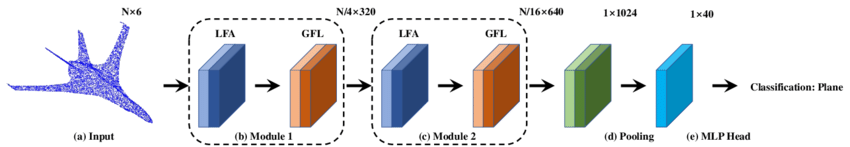

In [61]:
# Figure for the 3DCTN architecture
Image('3DCTN.png', retina=True, width=500)

## Model Implementation

In [ ]:
# Implementing the 3DCTN Model as a PyTorch module
%pip install einops

def timeit(tag, t):
    print("{}: {}s".format(tag, time() - t))
    return time()

def pc_normalize(pc):
    l = pc.shape[0]
    centroid = np.mean(pc, axis=0)
    pc = pc - centroid
    m = np.max(np.sqrt(np.sum(pc**2, axis=1)))
    pc = pc / m
    return pc

def square_distance(src, dst):
    """
    Calculate Euclid distance between each two points.

    src^T * dst = xn * xm + yn * ym + zn * zm；
    sum(src^2, dim=-1) = xn*xn + yn*yn + zn*zn;
    sum(dst^2, dim=-1) = xm*xm + ym*ym + zm*zm;
    dist = (xn - xm)^2 + (yn - ym)^2 + (zn - zm)^2
         = sum(src**2,dim=-1)+sum(dst**2,dim=-1)-2*src^T*dst

    Input:
        src: source points, [B, N, C]
        dst: target points, [B, M, C]
    Output:
        dist: per-point square distance, [B, N, M]
    """
    B, N, _ = src.shape
    _, M, _ = dst.shape
    dist = -2 * torch.matmul(src, dst.permute(0, 2, 1))
    dist += torch.sum(src ** 2, -1).view(B, N, 1)
    dist += torch.sum(dst ** 2, -1).view(B, 1, M)
    return dist


def index_points(points, idx):
    """

    Input:
        points: input points data, [B, N, C]
        idx: sample index data, [B, S]
    Return:
        new_points:, indexed points data, [B, S, C]
    """
    device = points.device
    B = points.shape[0]
    view_shape = list(idx.shape)
    view_shape[1:] = [1] * (len(view_shape) - 1)
    repeat_shape = list(idx.shape)
    repeat_shape[0] = 1
    batch_indices = torch.arange(B, dtype=torch.long).to(device).view(view_shape).repeat(repeat_shape)
    new_points = points[batch_indices, idx, :]
    return new_points


def farthest_point_sample(xyz, npoint):
    """
    Input:
        xyz: pointcloud data, [B, N, 3]
        npoint: number of samples
    Return:
        centroids: sampled pointcloud index, [B, npoint]
    """
    device = xyz.device
    B, N, C = xyz.shape
    centroids = torch.zeros(B, npoint, dtype=torch.long).to(device)
    distance = torch.ones(B, N).to(device) * 1e10
    farthest = torch.randint(0, N, (B,), dtype=torch.long).to(device)
    batch_indices = torch.arange(B, dtype=torch.long).to(device)
    for i in range(npoint):
        centroids[:, i] = farthest
        centroid = xyz[batch_indices, farthest, :].view(B, 1, 3)
        dist = torch.sum((xyz - centroid) ** 2, -1)
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = torch.max(distance, -1)[1]
    return centroids


def query_ball_point(radius, nsample, xyz, new_xyz):
    """
    Input:
        radius: local region radius
        nsample: max sample number in local region
        xyz: all points, [B, N, 3]
        new_xyz: query points, [B, S, 3]
    Return:
        group_idx: grouped points index, [B, S, nsample]
    """
    device = xyz.device
    B, N, C = xyz.shape
    _, S, _ = new_xyz.shape
    group_idx = torch.arange(N, dtype=torch.long).to(device).view(1, 1, N).repeat([B, S, 1])
    sqrdists = square_distance(new_xyz, xyz)
    group_idx[sqrdists > radius ** 2] = N
    group_idx = group_idx.sort(dim=-1)[0][:, :, :nsample]
    # group_first = group_idx[:, :, 0].view(B, S, 1).repeat([1, 1, nsample])
    group_first = group_idx[:, :, 0].repeat([1, 1, nsample])
    mask = group_idx == N
    group_idx[mask] = group_first[mask]
    return group_idx


def sample_and_group(npoint, radius, nsample, xyz, points, returnfps=False):
    """
    Input:
        npoint:
        radius:
        nsample:
        xyz: input points position data, [B, N, 3]
        points: input points data, [B, N, D]
    Return:
        new_xyz: sampled points position data, [B, npoint, nsample, 3]
        new_points: sampled points data, [B, npoint, nsample, 3+D]
    """
    B, N, C = xyz.shape
    S = npoint
    fps_idx = farthest_point_sample(xyz, npoint) # [B, npoint, C]
    new_xyz = index_points(xyz, fps_idx)
    idx = query_ball_point(radius, nsample, xyz, new_xyz)
    grouped_xyz = index_points(xyz, idx) # [B, npoint, nsample, C]
    grouped_xyz_norm = grouped_xyz - new_xyz.view(B, S, 1, C)

    if points is not None:
        grouped_points = index_points(points, idx)
        new_points = torch.cat([grouped_xyz_norm, grouped_points], dim=-1) # [B, npoint, nsample, C+D]
    else:
        new_points = grouped_xyz_norm
    if returnfps:
        return new_xyz, new_points, grouped_xyz, fps_idx
    else:
        return new_xyz, new_points


def sample_and_group_all(xyz, points):
    """
    Input:
        xyz: input points position data, [B, N, 3]
        points: input points data, [B, N, D]
    Return:
        new_xyz: sampled points position data, [B, 1, 3]
        new_points: sampled points data, [B, 1, N, 3+D]
    """
    device = xyz.device
    B, N, C = xyz.shape
    new_xyz = torch.zeros(B, 1, C).to(device)
    grouped_xyz = xyz.view(B, 1, N, C)
    if points is not None:
        new_points = torch.cat([grouped_xyz, points.view(B, 1, N, -1)], dim=-1)
    else:
        new_points = grouped_xyz
    return new_xyz, new_points

def sample_and_group_all_gt(xyz, points):
    """
    Input:
        xyz: input points position data, [B, N, 3]
        points: input points data, [B, N, D]
    Return:
        new_xyz: sampled points position data, [B, 1, 3]
        new_points: sampled points data, [B, 1, N, 3+D]
    """
    device = xyz.device
    B, N, C = xyz.shape
    new_xyz = xyz
    grouped_xyz = xyz.view(B, 1, N, C)

    relative_coord = grouped_xyz[:, :, None, :, :] - grouped_xyz[:,:, :, None, :]

    pos_dist_sqrt=relative_coord

    if points is not None:

        new_points =points.view(B, 1, N, -1)
    else:
        new_points = grouped_xyz
    return new_xyz, new_points, pos_dist_sqrt

class PatchMerging_avepooling(nn.Module):
    def __init__(self, n):
        super().__init__()

        self.avepooling_layer=nn.AdaptiveAvgPool2d((n,1))
        ####################################################

    def forward(self, x):

        x = x.permute(0, 3, 1, 2)
        x = self.avepooling_layer(x)
        x = x.permute(0, 2, 3, 1)
        
        return x


class WindowAttention(nn.Module):
    def __init__(self, input_dim, output_dim, heads, head_dim, patch_size, attn_drop_value):
        super().__init__()
        inner_dim = head_dim * heads

        self.heads = heads
        self.scale = head_dim ** -0.5
        self.patch_size = patch_size
        self.input_dim=input_dim 
        self.output_dim=output_dim

        self.linear_input = nn.Sequential(nn.Linear(input_dim, output_dim), nn.BatchNorm2d(output_dim), nn.ReLU(inplace=True))
        self.linear_out = nn.Sequential(nn.BatchNorm2d(output_dim), nn.ReLU(inplace=True))

        self.q_conv = nn.Conv2d(input_dim, output_dim, 1)
        self.k_conv = nn.Conv2d(input_dim, output_dim, 1)


        self.linear_p = nn.Sequential(nn.Linear(3, 3), nn.BatchNorm3d(3), nn.ReLU(inplace=True), nn.Linear(3, head_dim))
        self.linear_dots = nn.Sequential(nn.Linear(head_dim, head_dim), nn.ReLU(inplace=True), nn.Linear(head_dim, head_dim))


        self.v_conv = nn.Conv2d(input_dim, output_dim, 1)


        self.trans_conv = nn.Conv2d(output_dim, output_dim, 1)
        self.after_norm = nn.BatchNorm2d(output_dim)
        self.act = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, p_r):
        shortcut=x
        b, n, K, _, h = *x.shape, self.heads
        for i, layer in enumerate(self.linear_input): x = layer(x.permute(0, 3, 1, 2)).permute(0, 2, 3, 1) if i == 1 else layer(x)
        
        x_q = self.q_conv(x.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
        
        x_k = self.k_conv(x.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
        x_v = self.v_conv(x.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
        # b, n, k, c

        x_q = rearrange(x_q, 'b n k (h d) -> b h n k d',
                        h=h, k=K)
        x_k = rearrange(x_k, 'b n k (h d) -> b h n k d',
                        h=h, k=K)
        x_v = rearrange(x_v, 'b n k (h d) -> b h n k d',
                        h=h, k=K)
        # b,h,n,k,d
        dots = x_q[:,:,:, :, None, :]-x_k[:, :,:, None, :, :]
        # b,h,n,k,k
        
        for i, layer in enumerate(self.linear_p): p_r = layer(p_r.permute(0, 4, 1, 2, 3)).permute(0, 2, 3, 4, 1) if i == 1 else layer(p_r)
        # b,n,k,k,1

        p_r=p_r.unsqueeze(-1)
        # b,n,k,k, d,1

        p_r=p_r.permute(0,5,1,2,3,4)

        # b,1,n,k,k
        dots=dots+p_r

        for i, layer in enumerate(self.linear_dots): dots =  layer(dots)


        attention = self.softmax(dots)
        attention = attention / (1e-9 + attention.sum(dim=-2, keepdim=True)) 
        # b,h,n,k,k

        x_v=x_v.unsqueeze(-1)
        #b,h,n,k,d,1
        x_v=x_v.permute(0,1,2,5,3,4)
        #b,h,n,1,k,d

        out = attention * x_v
        # b,h,n,k,k,d
        # b,h,n,k,d

        out = rearrange(out, 'b h n k1 k2 d -> b n k1 k2 (h d)',
                                h=h, k1=K)
        # b,n,k,k,c
        out = torch.sum(out, dim=-2, keepdim=False)
        # b,n,k,c

        for i, layer in enumerate(self.linear_out): out = layer(out.permute(0, 3, 1, 2)).permute(0, 2, 3, 1) if i == 0 else layer(out)




        x_r = shortcut.permute(0, 3, 1, 2) + self.act(self.after_norm(self.trans_conv(shortcut.permute(0, 3, 1, 2) - out.permute(0, 3, 1, 2))))


        x_r=x_r.permute(0, 2, 3, 1)



       

        return x_r

class SwinBlock(nn.Module):
    def __init__(self, batchnorm, input_dim, output_dim, heads, head_dim, mlp_dim, patch_size, attn_drop_value, feed_drop_value):
        super().__init__()
        self.attention_block = WindowAttention(input_dim=input_dim, 
                                                output_dim=output_dim,
                                                heads=heads,
                                                head_dim=head_dim,
                                                patch_size=patch_size,
                                                attn_drop_value=attn_drop_value)

    def forward(self, x, pos_dist_sqrt):
        x = self.attention_block(x, pos_dist_sqrt)
        return x

class PointNetSetAbstraction(nn.Module):
    def __init__(self, npoint, radius, nsample, in_channel, mlp, group_all):
        super(PointNetSetAbstraction, self).__init__()
        self.npoint = npoint
        self.radius = radius
        self.nsample = nsample
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        last_channel = in_channel
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv2d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm2d(out_channel))
            last_channel = out_channel
        self.group_all = group_all

    def forward(self, xyz, points):
        """
        Input:
            xyz: input points position data, [B, C, N]
            points: input points data, [B, D, N]
        Return:
            new_xyz: sampled points position data, [B, C, S]
            new_points_concat: sample points feature data, [B, D', S]
        """
        xyz = xyz.permute(0, 2, 1)
        if points is not None:
            points = points.permute(0, 2, 1)

        if self.group_all:
            new_xyz, new_points = sample_and_group_all(xyz, points)
        else:
            new_xyz, new_points = sample_and_group(self.npoint, self.radius, self.nsample, xyz, points)
        # new_xyz: sampled points position data, [B, npoint, C]
        # new_points: sampled points data, [B, npoint, nsample, C+D]
        new_points = new_points.permute(0, 3, 2, 1) # [B, C+D, nsample,npoint]
        for i, conv in enumerate(self.mlp_convs):
            bn = self.mlp_bns[i]
            new_points =  F.relu(bn(conv(new_points)), inplace=True)

        new_points = torch.max(new_points, 2)[0]
        new_xyz = new_xyz.permute(0, 2, 1)
        return new_xyz, new_points

class Global_Transformer(nn.Module):
    def __init__(self, avepooling, batchnorm, attn_drop_value, feed_drop_value, npoint, in_channel, out_channels, layers, num_heads, head_dim):
        super(Global_Transformer, self).__init__()
        self.npoint = npoint
        self.avepooling = avepooling

        

        
        self.layer = SwinBlock(batchnorm, input_dim=in_channel, output_dim=out_channels, heads=num_heads, head_dim=head_dim, mlp_dim=in_channel * 4,
                          patch_size=npoint, attn_drop_value=attn_drop_value, feed_drop_value=feed_drop_value)
        
        self.avepooling_layer=PatchMerging_avepooling(1)
        #################################################################################################

    def forward(self, xyz, points):
        """
        Input:
            xyz: input points position data, [B, C, N]
            points: input points data, [B, D, N]
        Return:
            new_xyz: sampled points position data, [B, C, S]
            new_points_concat: sample points feature data, [B, D', S]
        """
        

        xyz = xyz.permute(0, 2, 1)
        if points is not None:
            points = points.permute(0, 2, 1)

        new_xyz, new_points, pos_dist_sqrt = sample_and_group_all_gt(xyz, points)
        # new_xyz: sampled points position data, [B, npoint, 3]
        # new_points: sampled points data, [B, 1, npoint, D]
        B, S, _ = new_xyz.shape
        ######################################################################
        
 
        new_points=self.layer(new_points, pos_dist_sqrt)
        if self.avepooling:
            new_points=self.avepooling_layer(new_points)
            new_points=new_points.view(B,1,-1) # B,1, D

        else:
            new_points=new_points.contiguous().view(B,S,-1) # B,S, D
        #####################################################################
        
        new_xyz = new_xyz.permute(0, 2, 1)
        new_points = new_points.permute(0, 2, 1)
        return new_xyz, new_points

class PointNetSetAbstractionMsg(nn.Module):
    def __init__(self, npoint, radius_list, nsample_list, in_channel, mlp_list):
        super(PointNetSetAbstractionMsg, self).__init__()
        self.npoint = npoint
        self.radius_list = radius_list
        self.nsample_list = nsample_list
        self.conv_blocks = nn.ModuleList()
        self.bn_blocks = nn.ModuleList()
        for i in range(len(mlp_list)):
            convs = nn.ModuleList()
            bns = nn.ModuleList()
            last_channel = 2*in_channel + 3
            for out_channel in mlp_list[i]:
                convs.append(nn.Conv2d(last_channel, out_channel, 1))
                bns.append(nn.BatchNorm2d(out_channel))
                last_channel = out_channel
            self.conv_blocks.append(convs)
            self.bn_blocks.append(bns)

    def forward(self, xyz, points):
        """
        Input:
            xyz: input points position data, [B, C, N]
            points: input points data, [B, D, N]
        Return:
            new_xyz: sampled points position data, [B, C, S]
            new_points_concat: sample points feature data, [B, D', S]
        """
        xyz = xyz.permute(0, 2, 1)
        if points is not None:
            points = points.permute(0, 2, 1)

        B, N, C = xyz.shape
        _, _, D = points.shape
        S = self.npoint

        fps_index=farthest_point_sample(xyz, S)

        new_xyz = index_points(xyz, fps_index)
        new_points_ori = index_points(points, fps_index) # B S D

        new_points_list = []
        for i, radius in enumerate(self.radius_list):
            K = self.nsample_list[i]
            group_idx = query_ball_point(radius, K, xyz, new_xyz)
            grouped_xyz = index_points(xyz, group_idx)
            grouped_xyz -= new_xyz.view(B, S, 1, C)



            if points is not None:
                grouped_points = index_points(points, group_idx)
                new_points_ori_K=new_points_ori
                new_points_ori_K = new_points_ori_K.contiguous().view(B, S, 1, D).repeat(1, 1, K, 1)
                grouped_points=torch.cat((grouped_points-new_points_ori_K, new_points_ori_K), dim=-1).contiguous()
                grouped_points = torch.cat([grouped_points, grouped_xyz], dim=-1)
            else:
                grouped_points = grouped_xyz

            grouped_points = grouped_points.permute(0, 3, 2, 1)  # [B, D, K, S]
            for j in range(len(self.conv_blocks[i])):
                conv = self.conv_blocks[i][j]
                bn = self.bn_blocks[i][j]
                grouped_points =  F.relu(bn(conv(grouped_points)), inplace=True)
            new_points = torch.max(grouped_points, 2)[0]  # [B, D', S]
            new_points_list.append(new_points)

        new_xyz = new_xyz.permute(0, 2, 1)
        new_points_concat = torch.cat(new_points_list, dim=1)
        return new_xyz, new_points_concat


class PointNetFeaturePropagation(nn.Module):
    def __init__(self, in_channel, mlp):
        super(PointNetFeaturePropagation, self).__init__()
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        last_channel = in_channel
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv1d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm1d(out_channel))
            last_channel = out_channel

    def forward(self, xyz1, xyz2, points1, points2):
        """
        Input:
            xyz1: input points position data, [B, C, N]
            xyz2: sampled input points position data, [B, C, S]
            points1: input points data, [B, D, N]
            points2: input points data, [B, D, S]
        Return:
            new_points: upsampled points data, [B, D', N]
        """
        xyz1 = xyz1.permute(0, 2, 1)
        xyz2 = xyz2.permute(0, 2, 1)

        points2 = points2.permute(0, 2, 1)
        B, N, C = xyz1.shape
        _, S, _ = xyz2.shape

        if S == 1:
            interpolated_points = points2.repeat(1, N, 1)
        else:
            dists = square_distance(xyz1, xyz2)
            dists, idx = dists.sort(dim=-1)
            dists, idx = dists[:, :, :3], idx[:, :, :3]  # [B, N, 3]

            dist_recip = 1.0 / (dists + 1e-8)
            norm = torch.sum(dist_recip, dim=2, keepdim=True)
            weight = dist_recip / norm
            interpolated_points = torch.sum(index_points(points2, idx) * weight.view(B, N, 3, 1), dim=2)

        if points1 is not None:
            points1 = points1.permute(0, 2, 1)
            new_points = torch.cat([points1, interpolated_points], dim=-1)
        else:
            new_points = interpolated_points

        new_points = new_points.permute(0, 2, 1)
        for i, conv in enumerate(self.mlp_convs):
            bn = self.mlp_bns[i]
            new_points = F.relu(bn(conv(new_points)), inplace=True)
        return new_points


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class get_model(nn.Module):
    def __init__(self,num_class,normal_channel=True):
        super(get_model, self).__init__()
        in_channel = 3 if normal_channel else 0
        self.normal_channel = normal_channel
        self.sa1 = PointNetSetAbstractionMsg(256, [0.1, 0.2, 0.4], [16, 32, 128], in_channel,[[32, 32, 64], [64, 64, 128], [64, 96, 128]])
        self.global_sa1 = Global_Transformer(avepooling=False, batchnorm=True, attn_drop_value=0, feed_drop_value=0, npoint=256, in_channel=320, out_channels=320, layers=1, num_heads=10, head_dim=32)
        self.sa2 = PointNetSetAbstractionMsg(64, [0.2, 0.4, 0.8], [32, 64, 128], 320,[[64, 64, 128], [128, 128, 256], [128, 128, 256]])
        self.global_sa2 = Global_Transformer(avepooling=False, batchnorm=True, attn_drop_value=0, feed_drop_value=0, npoint=64, in_channel=640, out_channels=640, layers=1, num_heads=20, head_dim=32)
        self.sa3 = PointNetSetAbstraction(None, None, None, 640 + 3, [256, 512, 1024], True)

        
        self.fc1 = nn.Linear(1024, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.drop1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.drop2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, num_class)

    def forward(self, xyz):
        B, _, _ = xyz.shape
        if self.normal_channel:
            norm = xyz[:, 3:, :]
            xyz = xyz[:, :3, :]
        else:
            norm = None
        l1_xyz, l1_points = self.sa1(xyz, norm)
        g1_xyz, g1_points = self.global_sa1(l1_xyz, l1_points)

        l2_xyz, l2_points = self.sa2(g1_xyz, g1_points)
        g2_xyz, g2_points = self.global_sa2(l2_xyz, l2_points)

        l3_xyz, l3_points = self.sa3(g2_xyz, g2_points)
        x = l3_points.view(B, 1024)
        x = self.drop1(F.relu(self.bn1(self.fc1(x)), inplace=True))
        x = self.drop2(F.relu(self.bn2(self.fc2(x)), inplace=True))
        x = self.fc3(x)
        x = F.log_softmax(x, -1)


        return x,l3_points


class get_loss(nn.Module):
    def __init__(self):
        super(get_loss, self).__init__()

    def forward(self, pred, gold, smoothing=True):
        gold = gold.contiguous().view(-1)

        if smoothing:
            eps = 0.2
            n_class = pred.size(1)

            one_hot = torch.zeros_like(pred).scatter(1, gold.view(-1, 1), 1)
            one_hot = one_hot * (1 - eps) + (1 - one_hot) * eps / (n_class - 1)
            log_prb = F.log_softmax(pred, dim=1)

            loss = -(one_hot * log_prb).sum(dim=1).mean()
        else:
            loss = F.cross_entropy(pred, gold, reduction='mean')

        return loss

def inplace_relu(m):
    classname = m.__class__.__name__
    if classname.find('ReLU') != -1:
        m.inplace=True

In [ ]:
num_class = 40
model=get_model(num_class=num_class,normal_channel=True)
criterion = get_loss()
model.apply(inplace_relu)

get_model(
  (sa1): PointNetSetAbstractionMsg(
    (conv_blocks): ModuleList(
      (0): ModuleList(
        (0): Conv2d(9, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        (2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): ModuleList(
        (0): Conv2d(9, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      )
      (2): ModuleList(
        (0): Conv2d(9, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1))
        (2): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (bn_blocks): ModuleList(
      (0): ModuleList(
        (0-1): 2 x BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
     

In [ ]:
model = model.cuda()
criterion = criterion.cuda()

# Download the model
!wget https://github.com/SanjayJosh/3DCTN/raw/feat/best_model.zip
!unzip -o best_model.zip
!ls

--2023-05-03 22:09:56--  https://github.com/SanjayJosh/3DCTN/raw/feat/best_model.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/SanjayJosh/3DCTN/feat/best_model.zip [following]
--2023-05-03 22:09:56--  https://raw.githubusercontent.com/SanjayJosh/3DCTN/feat/best_model.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32925570 (31M) [application/zip]
Saving to: ‘best_model.zip.3’

best_model.zip.3    100%[===================>]  31.40M   165MB/s    in 0.2s    

2023-05-03 22:09:56 (165 MB/s) - ‘best_model.zip.3’ saved [32925570/32925570]

Archive:  best_model.zip
  inflating: best_model

In [ ]:
checkpoint = torch.load('best_model.pth')
start_epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['model_state_dict'])

## 3DCTN: Training

#### Hyperparameters (best values)

* Learning rate η: 
* Batch size N:
* Epochs: 
* Optimizer: Adam
* Scheduler step size:
* Scheduler gamma:


In [ ]:
# 3DCTN hyperparameters
CTNModel = CTN()
ctn_learning_rate = 0.001
ctn_batch_size = 64
ctn_epochs = 20
ctn_optimizer = optim.Adam(CTNModel.parameters(), lr=sv_learning_rate)
ctn_scheduler = optim.lr_scheduler.StepLR(ctn_optimizer, step_size=10, gamma=0.5)

In [ ]:
# PORT TO MODULE
# Implementing one training step for 3DCTN
def train(model, optimizer, criterion, train_loader, scheduler=None, device='cuda'):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Performing model update using all batches
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.view(-1, output.size(-1)), target.view(-1))
        total_loss += loss.item()
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
        loss.backward()
        optimizer.step()

        # Learning rate scheduling
        if scheduler is not None:
            scheduler.step()
    
    # Computing training loss
    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * correct / total
    
    # Testing the model performance after the model update
    model.eval()
    with torch.no_grad():
        test_loss = 0
        test_correct = 0
        test_total = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output.view(-1, output.size(-1)), target.view(-1)).item()
            pred = output.max(1, keepdim=True)[1]
            test_correct += pred.eq(target.view_as(pred)).sum().item()
            test_total += target.size(0)
        avg_test_loss = test_loss / len(test_loader)
        test_accuracy = 100. * test_correct / test_total
    
    return avg_train_loss, train_accuracy, avg_test_loss, test_accuracy

In [ ]:
# Training 3DCTN
current_device = 'cuda' if torch.cuda.is_available() else 'cpu'
CTNModel.to(current_device)

for epoch in range(sv_epochs):
    avg_train_loss, train_accuracy, avg_test_loss, test_accuracy = train(CTNModel, ctn_optimizer, nn.CrossEntropyLoss(), train_loader, ctn_scheduler, current_device)
    print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%  Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

## 3DCTN: Testing

Characterizing the performance of the 3DCTN Model

In [ ]:
# Testing 3DCTN Classification accuracy

Confusion matrix

In [ ]:
# Plotting the confusion matrix for classification

# **Adversarial Attacks**
In this section, we examine the SimpleView Model and 3DCTN in terms of their resilience against adversarial attacks. We consider two kinds

## One-point attacks

In this sub-section, we implement one-point attacks on the SimpleView and 3DCTN model. Under this attack, we just perturb one point within the point cloud corresponding to 

In [ ]:
def one_point_attack(model, criterion, input_point_cloud, true_label, target_label, max_iterations=1000, perturb_amount=0.01):
    """
    Performs a one-point attack on a given model for 3D point cloud classification.
    """
    model.eval()
    
    # Clone the input point cloud
    perturbed_point_cloud = input_point_cloud.clone().detach().requires_grad_(True)
    
    # Compute the gradient of the loss with respect to each point in the input point cloud
    # This is for finding the best pixel to execute the attack on
    logits = model(perturbed_point_cloud.unsqueeze(0))
    loss = torch.nn.functional.cross_entropy(logits, torch.tensor([true_label]))
    gradients = torch.autograd.grad(loss, perturbed_point_cloud)[0]
    gradient_norm = torch.norm(gradients, dim=1)
    
    # Select the point with the highest magnitude of gradient
    perturb_index = torch.argmax(gradient_norm).item()
    
    # Perform the attack for the specified number of iterations
    for i in tqdm(range(max_iterations)):
        # Zero out the gradients
        model.zero_grad()
        
        # Pass the perturbed point cloud through the model
        logits = model(perturbed_point_cloud.unsqueeze(0))
        
        # Calculate the loss between the predicted probabilities and the target label
        loss = criterion(logits, torch.tensor([target_label]))
        
        # Compute the gradient of the loss with respect to the perturbed point
        loss.backward(retain_graph=True)
        gradient = perturbed_point_cloud.grad[perturb_index]
        
        # Update the selected point using the gradient of the loss to maximize the loss
        perturbed_point_cloud[perturb_index] += perturb_amount * gradient / torch.norm(gradient)
        perturbed_point_cloud[perturb_index] = torch.clamp(perturbed_point_cloud[perturb_index], 0, 1)
        
        # Check if the target label has been achieved
        predicted_label = torch.argmax(logits, dim=1)
        if predicted_label == target_label:
            print(f'The model classification changed from {true_label} to {target_label} after {i} iterations.')
            break
    
    # Return the perturbed point cloud that achieves the target label
    return perturbed_point_cloud.detach()

#### SimpleView

In [ ]:
# Define the transformation to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Loading the trained SimpleView model
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleView('modelnet40', 'resnet18', 64).to(current_device) #
model.load_state_dict(torch.load('model.pt', map_location=current_device)) # Add path to the trained and saved model
criterion = nn.CrossEntropyLoss()

*Example 1*

In [ ]:
# Select a random point cloud from the test dataset
point_cloud, label = next(iter(test_loader))
point_cloud = point_cloud.to(current_device)
true_label = label.to(current_device)
initial_prediction = torch.argmax(model(point_cloud))

# Executing the attack
target_label = 3
perturbed_point_cloud = one_point_attack(model, point_cloud, true_label, target_label)

# Compute the final prediction and loss
final_outputs = model(perturbed_point_cloud)
final_prediction = torch.argmax(final_outputs)

# Print the results
print("Initial prediction:", initial_prediction)
print("Final prediction:", final_prediction)

In [ ]:
# Printing the point perturbance distance
print("Perturbation:", torch.sum(perturbed_point_cloud - point_cloud))

*Example 2*

In [ ]:
# Select a random point cloud from the test dataset
point_cloud, label = next(iter(test_loader))
point_cloud = point_cloud.to(current_device)
true_label = label.to(current_device)
initial_prediction = torch.argmax(model(point_cloud))

# Executing the attack
target_label = 3
perturbed_point_cloud = one_point_attack(model, point_cloud, true_label, target_label)

# Compute the final prediction and loss
final_outputs = model(perturbed_point_cloud)
final_prediction = torch.argmax(final_outputs)

# Print the results
print("Initial prediction:", initial_prediction)
print("Final prediction:", final_prediction)

In [ ]:
# Printing the point perturbance distance
print("Perturbation:", torch.sum(perturbed_point_cloud - point_cloud))

#### 3DCTN

In [ ]:
# Loading the trained CTN model
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transformation to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the model
# model = CTN(**********).to(current_device) # COMPLETE THIS INSTANTIATION
# print(torch.load('ctn_best.pth', map_location=current_device))
model.load_state_dict(torch.load('best_model_3dctn.pth', map_location=current_device)['model_state_dict']) # Add path to the trained and saved model
# criterion = nn.CrossEntropyLoss()

<All keys matched successfully>

*Example 1*

In [ ]:
# Select a random point cloud from the test dataset
test_loader = DataLoader(test_subset, batch_size=1, shuffle=False, num_workers=2)
# true_label = 2
# class_data = [data for data in dataset if data.y.item() == true_label]
batch = next(iter(test_loader))
point_cloud = batch.pos
label = batch.y[0]

point_cloud = point_cloud.to(current_device)
initial_prediction = torch.argmax(model(point_cloud.unsqueeze(0)))

# Executing the attack
target_label = 3
perturbed_point_cloud = one_point_attack(model, point_cloud, true_label, target_label)

# Compute the final prediction and loss
final_outputs = model(perturbed_point_cloud)
final_prediction = torch.argmax(final_outputs)

# Print the results
print("Initial prediction:", initial_prediction)
print("Final prediction:", final_prediction)

In [ ]:
# Printing the point perturbance distance
print("Perturbation:", torch.sum(perturbed_point_cloud - point_cloud))

*Example 2*

In [ ]:
# Select a random point cloud from the test dataset
point_cloud, label = next(iter(test_loader))
point_cloud = point_cloud.to(current_device)
true_label = label.to(current_device)
initial_prediction = torch.argmax(model(point_cloud))

# Executing the attack
target_label = 3
perturbed_point_cloud = one_point_attack(model, point_cloud, true_label, target_label)

# Compute the final prediction and loss
final_outputs = model(perturbed_point_cloud)
final_prediction = torch.argmax(final_outputs)

# Print the results
print("Initial prediction:", initial_prediction)
print("Final prediction:", final_prediction)

In [ ]:
# Printing the point perturbance distance
print("Perturbation:", torch.sum(perturbed_point_cloud - point_cloud))

## Noise attacks

In this sub-section, we implement imperceptible noise attacks on the SimpleView and 3DCTN model. Under this attack, we perturb the model point cloud globally and regularize w.r.t the overall displacement of all points.

In [ ]:
def noise_attack(model, criterion, input_point_cloud, true_label, target_label, max_iterations=1000, perturb_amount=0.01):
    """
    Performs a noise attack on a given model for 3D point cloud classification using gradient ascent.
    """
    model.eval()
    
    # Clone the input point cloud
    perturbed_point_cloud = input_point_cloud.clone().detach().requires_grad_(True)
    
    # Perform the attack for the specified number of iterations
    for i in tqdm(range(max_iterations)):
        # Zero out the gradients
        model.zero_grad()
        
        # Pass the perturbed point cloud through the model
        logits = model(perturbed_point_cloud.unsqueeze(0))
        
        # Calculate the loss between the predicted probabilities and the target label
        loss = criterion(logits, torch.tensor([target_label]))
        
        # Compute the gradient of the loss with respect to the perturbed point cloud
        loss.backward(retain_graph=True)
        gradients = perturbed_point_cloud.grad
        
        # Update the perturbed point cloud using the gradient of the loss to maximize the loss
        perturbed_point_cloud += perturb_amount * gradients / torch.norm(gradients)
        perturbed_point_cloud = torch.clamp(perturbed_point_cloud, 0, 1)
        
        # Check if the target label has been achieved
        predicted_label = torch.argmax(logits, dim=1)
        if predicted_label == target_label:
            print(f'The model classification changed from {true_label} to {target_label} after {i} iterations.')
            break
    
    # Return the perturbed point cloud that achieves the target label
    return perturbed_point_cloud.detach()

In [ ]:
# Utilities for gauging the success of the noise attacks
def calc_mean_perturbation(pc1, pc2):
    """
    Calculates the average displacement between two point clouds.
    """
    return np.mean(np.linalg.norm(pc1 - pc2, axis=1))

def calc_mean_diff(pc1, pc2):
    """
    Calculates the absolute difference between two point clouds.
    """
    return np.mean(np.abs(pc1 - pc2))

#### Simple View

In [ ]:
# Define the transformation to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Loading the trained SimpleView model
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleView('modelnet40', 'resnet18', 64).to(current_device) #
model.load_state_dict(torch.load('model.pt', map_location=current_device)) # Add path to the trained and saved model
criterion = nn.CrossEntropyLoss()

*Example 1*

In [ ]:
# Select a random point cloud from the test dataset
point_cloud, label = next(iter(test_loader))
point_cloud = point_cloud.to(current_device)
true_label = label.to(current_device)
initial_prediction = torch.argmax(model(point_cloud))

# Executing the attack
target_label = 3
perturbed_point_cloud = noise_attack(model, point_cloud, true_label, target_label)

# Compute the final prediction and loss
final_outputs = model(perturbed_point_cloud)
final_prediction = torch.argmax(final_outputs)

# Print the results
print("Initial prediction:", initial_prediction)
print("Final prediction:", final_prediction)

In [ ]:
# Printing the average point displacement and point cloud difference
displacement = calc_mean_perturbation(point_cloud.numpy(), perturbed_point_cloud.numpy())
cloud_diff = calc_mean_diff(point_cloud.numpy(), perturbed_point_cloud.numpy())
print(f"Average point displacement: {displacement}")
print(f"Point cloud difference: {cloud_diff}")

*Example 2*

In [ ]:
# Select a random point cloud from the test dataset
point_cloud, label = next(iter(test_loader))
point_cloud = point_cloud.to(current_device)
true_label = label.to(current_device)
initial_prediction = torch.argmax(model(point_cloud))

# Executing the attack
target_label = 3
perturbed_point_cloud = noise_attack(model, point_cloud, true_label, target_label)

# Compute the final prediction and loss
final_outputs = model(perturbed_point_cloud)
final_prediction = torch.argmax(final_outputs)

# Print the results
print("Initial prediction:", initial_prediction)
print("Final prediction:", final_prediction)

In [ ]:
# Printing the average point displacement and point cloud difference
displacement = calc_mean_perturbation(point_cloud.numpy(), perturbed_point_cloud.numpy())
cloud_diff = calc_mean_diff(point_cloud.numpy(), perturbed_point_cloud.numpy())
print(f"Average point displacement: {displacement}")
print(f"Point cloud difference: {cloud_diff}")

#### 3DCTN

In [ ]:
# Loading the trained CTN model
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transformation to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the model
model = CTN(**********).to(current_device) # COMPLETE THIS INSTANTIATION
model.load_state_dict(torch.load('model.pt', map_location=current_device)) # Add path to the trained and saved model
criterion = nn.CrossEntropyLoss()

*Example 1*

In [ ]:
# Select a random point cloud from the test dataset
point_cloud, label = next(iter(test_loader))
point_cloud = point_cloud.to(current_device)
true_label = label.to(current_device)
initial_prediction = torch.argmax(model(point_cloud))

# Executing the attack
target_label = 3
perturbed_point_cloud = noise_attack(model, point_cloud, true_label, target_label)

# Compute the final prediction and loss
final_outputs = model(perturbed_point_cloud)
final_prediction = torch.argmax(final_outputs)

# Print the results
print("Initial prediction:", initial_prediction)
print("Final prediction:", final_prediction)

In [ ]:
# Printing the average point displacement and point cloud difference
displacement = calc_mean_perturbation(point_cloud.numpy(), perturbed_point_cloud.numpy())
cloud_diff = calc_mean_diff(point_cloud.numpy(), perturbed_point_cloud.numpy())
print(f"Average point displacement: {displacement}")
print(f"Point cloud difference: {cloud_diff}")

*Example 2*

In [ ]:
# Select a random point cloud from the test dataset
point_cloud, label = next(iter(test_loader))
point_cloud = point_cloud.to(current_device)
true_label = label.to(current_device)
initial_prediction = torch.argmax(model(point_cloud))

# Executing the attack
target_label = 3
perturbed_point_cloud = noise_attack(model, point_cloud, true_label, target_label)

# Compute the final prediction and loss
final_outputs = model(perturbed_point_cloud)
final_prediction = torch.argmax(final_outputs)

# Print the results
print("Initial prediction:", initial_prediction)
print("Final prediction:", final_prediction)

In [ ]:
# Printing the average point displacement and point cloud difference
displacement = calc_mean_perturbation(point_cloud.numpy(), perturbed_point_cloud.numpy())
cloud_diff = calc_mean_diff(point_cloud.numpy(), perturbed_point_cloud.numpy())
print(f"Average point displacement: {displacement}")
print(f"Point cloud difference: {cloud_diff}")

# **Results and Conclusion**

We trained our models using the Google Cloud Platform credits provided to us. The training was done on runtimes (Deep Learning VMs) with Nvidia V100 GPU, for 140 epochs over 11 hours of training time.

In this comparatory study, we focus on evaluating the performance of the SimpleView (Multi-View CNN) model and the 3D-CTN model, as the proposed transformer-based model has been dropped. We aim to identify the strengths and weaknesses of each approach based on their classification performance, computational efficiency, and robustness.

#### **Classification Performance**

The SimpleView model leverages 2D CNNs to classify objects based on multiple depth images, which may limit its ability to fully capture the 3D structure of objects. On the other hand, the 3D-CTN model directly processes raw 3D point cloud data and captures both local and global features, which may lead to a more accurate classification performance.

#### **Computational Efficiency**
The SimpleView model requires pre-processing of 3D point cloud data into multiple 2D depth images, which adds extra computational overhead. The 3D-CTN model, however, directly processes the raw 3D point cloud data, making it more computationally efficient in this regard. However, the 3D-CTN model may also require more complex calculations due to its use of graph convolutions and transformer mechanisms, which could affect its overall efficiency.

#### **Robustness**
The SimpleView model's reliance on multiple-depth images may make it more sensitive to variations in object orientation and occlusions. The 3D-CTN model, by capturing both local and global features directly from the point cloud data, is likely to be more robust against such variations. However, the robustness of both models to adversarial attacks and other challenges would need to be evaluated through extensive experimentation.

#### **Scalability** 
The scalability of each model depends on the complexity of the architecture and the size of the input data. The SimpleView model requires multiple depth images, which may increase the size of the input data, while the 3D-CTN model works directly with the raw point cloud data. However, the latter's use of graph convolutions and transformer mechanisms may increase the complexity of the architecture, potentially affecting its scalability.
